<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/bi-2022/blob/main/notebooks/bi_2021_04_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobieramy dane z github wykorzystując funkcję `download.file`

In [1]:
download.file("https://raw.githubusercontent.com/DepartmentOfStatisticsPUE/bi-2021/main/data/popyt-zajecia-dane.csv",
              "popyt-dane.csv")

Musimy dane wczytać do R

In [2]:
dane <- read.csv("popyt-dane.csv", stringsAsFactors = FALSE)
head(dane)

,id_popyt,id_jednostki,waga,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<int>,<int>
1,1,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,1,2,NA,NA,NA,NA,NA
2,2,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,2,7,NA,NA,NA,NA,NA
3,3,c9dbaf50890165ebe810aa770de0e9df903dc35b,6,1,D,O,24,2,6,NA,NA,NA,NA,NA
4,4,718e0bba42bcec6ed98f9690db6d26cb7b93c880,1,1,D,R.S,14,2,7,NA,NA,NA,NA,NA
5,5,532a1879a692b9d7bbb7282ba757d028156ef341,1,1,D,R.S,14,2,6,NA,NA,NA,NA,NA
6,6,0b6b623fa45e257284a3049d097af322841337e3,1,1,D,R.S,22,2,1,NA,NA,NA,NA,NA


Załadujmy pakiet `tidyverse` do przetwarzania danych.

In [ ]:
library(tidyverse)

Porównamy sobie rozkłady liczby ofert pracy w popycie oraz CBOP według wielkości przedsiębiorstwa.

In [4]:
dane %>%
  ## wybieram dane z popytu
  filter(!is.na(id_popyt)) %>%
  ## wyliczam ile było wolnych miejsc pracy wykorzystując funkcję count i wagę
  count(klasa_pr, wt = waga*wolne_miejsca) %>%
  ## obliczam odsetek
  mutate(odsetek = n / sum(n)*100,
         zrodlo = "popyt") -> dane_wielk_popyt

dane %>%
  ## wybieram dane z CBOP
  filter(!is.na(id_cbop)) %>%
  ## obliczam ile było wolnych miejsc pracy
  count(klasa_pr, wt = wolne_miejsca_cbop) %>%
  ## obliczam odsetek
  mutate(odsetek = n / sum(n)*100,
         zrodlo = "cbop") -> dane_wielk_cbop

Porównuje odsetki między dwoma zbiorami danych

In [5]:
dane_wielk_popyt %>%
  select(-n) %>% 
  bind_rows(dane_wielk_cbop %>% select(-n)) %>%
  spread(zrodlo, odsetek)

klasa_pr,cbop,popyt
<chr>,<dbl>,<dbl>
D,51.97230,31.98298
M,23.79764,43.81333
S,24.23007,24.20369


Utwórzmy wartości globalne, które wykorzystamy do post-stratyfikacji. Na tę chwilę wykorzystamy wyłącznie informacje o wielkości podmiotu.

In [6]:
dane_wielk_popyt %>%
  select(klasa_pr, pop = n) -> wartosci_globalne

wartosci_globalne

klasa_pr,pop
<chr>,<int>
D,94124
M,128940
S,71230


Dodajemy do zbioru danych z centralnej bazy ofert pracy informacje o wartościach globalnych z popytu.

In [7]:
dane %>% 
  ## wybieram dane z cbop
  filter(!is.na(id_cbop)) %>%
  ## ograniczam do wybranych kolumn
  select(id_cbop, klasa_pr, jedna_zmiana, wymiar_40, wolne_miejsca_cbop)  %>%
  mutate(jedna_zmiana = as.numeric(jedna_zmiana))-> zbior_cbop


wagi <- zbior_cbop %>%
  ## tworzę podsumowanie według klasy wielkości
  group_by(klasa_pr) %>%
  ## obliczam średnie i liczebności w danym przekroju
  summarise(zmiana = weighted.mean(jedna_zmiana, wolne_miejsca_cbop),
            n = sum(wolne_miejsca_cbop)) %>%
  ## dodaje wartości globalne z popytu
  left_join(wartosci_globalne) %>%
  ## obliczam wagę post-stratyfikacyjną
  mutate(waga = pop / n)

wagi

Joining, by = "klasa_pr"


klasa_pr,zmiana,n,pop,waga
<chr>,<dbl>,<int>,<int>,<dbl>
D,0.2978421,14783,94124,6.367043
M,0.7596395,6769,128940,19.048604
S,0.7021184,6892,71230,10.335171


Estymacja z wykorzystaniem tych wag

In [8]:
wagi %>% 
summarise(y_naive = weighted.mean(zmiana, n),
          y_ps = weighted.mean(zmiana, waga*n))

y_naive,y_ps
<dbl>,<dbl>
0.5056954,0.5980207


Komentarz do uzyskanych wyników:


1.   Estymator naiwny (`y_naive`) obliczony wyłącznie na podstawie danych z CBOP informuje, że 51% podmiotów miało wakaty, które są na na jedną zmianę.
2.   Estymator post-stratyfikcyjny (`y_ps`) obliczony na danych z CBOP ale uwzględniajac różnicę w rozkłdach ze względu na wielkość firmy informuje, że (prawdopodobinie) odsetek ten w populacji jest wyższy i wynosci 60%.

Jeżeli widzą Państwo różnicę w wartościach miedzy `y_naive`, a `y_ps` to oznacza, że zmienna wykorzystana do post-stratyfikacji działa (bo różnicuje populację). Można to sprawdzić licząc wcześniej współczynnik korelacji V-Cramer'a na podstawie statystyki $\chi^2$.



In [9]:
tab1 <- xtabs(wolne_miejsca_cbop ~ jedna_zmiana + klasa_pr, data = zbior_cbop)
summary(tab1)

Call: xtabs(formula = wolne_miejsca_cbop ~ jedna_zmiana + klasa_pr, 
    data = zbior_cbop)
Number of cases in table: 28444 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 5365, df = 2, p-value = 0

In [ ]:
install.packages("vcd") ## V Cramera

In [11]:
library(vcd)

Loading required package: grid



In [12]:
assocstats(tab1)

                    X^2 df P(> X^2)
Likelihood Ratio 5560.2  2        0
Pearson          5365.1  2        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.398 
Cramer's V        : 0.434 

## post-stratyfikacja z wykorzystaniem pakietu `survey`

In [13]:
install.packages("survey")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘minqa’, ‘numDeriv’, ‘mitools’




In [ ]:
library(survey)

Funkcja `postStratify`:

```
postStratify(design, strata, population, partial = FALSE, ...)
```

gdzie:

+ `design` -- obiekt pakietu `survey`,
+ `strata` -- zmienne według, których chcemy dokonać post-stratyfikacji,
+ `population` -- wartości globalne zmiennych wykorzystywanych w post-stratyfikacji,
+ `partial` -- czy mają być pominięte warstwy, których nie ma w próbie (domyślnie fałsz).

Jak dokonać post-stratyfikacji z pakietem `survey`? Potrzeba do tego 3 kroków:

1. należy utworzyć obiekt `design` z wykorzystaniem funkcji `svydesign`, który jako dane wejściowe wykorzysta dane z próby nielosowej,
2. należy utworzyć obiekt z wartościami globalnymi,
3. stosujemy funkcję `postStratify` do utworzenia nowego obiektu `survey.design`, który uwzględnia wagi post-stratyfikacyjne,
4. estymujemy interesujące nas wartości funkcjami `svymean` czy `svytotal`.

Dokonamy teraz kalibracji wg zmiennej `klasa_pr` jak w powyższym przykładzie.

In [15]:
zbior_cbop_svy <- svydesign(id = ~1, strata = ~ klasa_pr, weights = ~wolne_miejsca_cbop, data = zbior_cbop)
zbior_cbop_svy

Stratified Independent Sampling design (with replacement)
svydesign(id = ~1, strata = ~klasa_pr, weights = ~wolne_miejsca_cbop, 
    data = zbior_cbop)

In [16]:
wartosci_globalne

klasa_pr,pop
<chr>,<int>
D,94124
M,128940
S,71230


In [17]:
zbior_cbop_svy_ps <- postStratify(design = zbior_cbop_svy, strata = ~ klasa_pr, population = wartosci_globalne)
svytable(~klasa_pr, zbior_cbop_svy_ps)

klasa_pr
     D      M      S 
 94124 128940  71230 

Mnożniki dla wag wejściowych (jak w kodzie z `pop/n`)

In [18]:
table(weights(zbior_cbop_svy_ps) / weights(zbior_cbop_svy))


6.36704322532639 10.3351712130006 19.0486039296794 
            3653             3734             4090 

In [19]:
print("===== przed post-stratyfikacją ===== ")
svymean(~jedna_zmiana, zbior_cbop_svy)
print("===== po post-stratyfikacją ===== ")
svymean(~jedna_zmiana, zbior_cbop_svy_ps)

[1] "===== przed post-stratyfikacją ===== "


               mean     SE
jedna_zmiana 0.5057 0.0126

[1] "===== po post-stratyfikacją ===== "


                mean     SE
jedna_zmiana 0.59802 0.0075

Post-stratyfikacja z dwiema zmiennymi jednocześnie

In [20]:
head(dane, n =2)

,id_popyt,id_jednostki,waga,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<int>,<int>
1,1,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,1,2,NA,NA,NA,NA,NA
2,2,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,2,7,NA,NA,NA,NA,NA


In [21]:
sekc_pkd_woj_total <- xtabs(waga*wolne_miejsca ~ sekc_pkd + woj, data = dane, subset = !is.na(id_popyt))
sekc_pkd_woj_total

        woj
sekc_pkd     2     4     6     8    10    12    14    16    18    20    22
     C    7756  4244   867  1652  5037  4699 10490  1799  1611   870  4389
     D.E   312   134    61   116    67   159   757   102    75    58   298
     F    3274   988   393   559  1283  7542  3636  1242  1112  1493  1393
     G    2082   482  3924  1023  4869  5349 23329   190  1630   148 10174
     H    1161   446    95   591   884   970  4903   506   824   124   769
     I    1087   379  1691    57   945   683  2625    65   112   289   270
     J     728   243    63    72   845  1710  4201    95    73   148   508
     K.L   943   245   118   162   568   964  2277    36    98    27   564
     M    2201    29    85    32  1072  2547  3451   122   419    13   461
     N    1516   274   296   180   101  1430  2313    70   156   234   495
     O     754   575   496   339   407   400  2915   269   326   356   681
     P     795   167   199    72   319   274  1645   113    63   112   322
     Q     90

In [22]:
klasa_pr_woj_total <- xtabs(waga*wolne_miejsca ~ klasa_pr + woj, data = dane, subset = !is.na(id_popyt))
klasa_pr_woj_total

        woj
klasa_pr     2     4     6     8    10    12    14    16    18    20    22
       D  8544  3434  4743  1807  5307  9951 24075  1689  2157  1553  5003
       M 11883  2154  2876  1756  9380 10256 24987  1451  3378  1800  9093
       S  3697  3044  1275  1690  2979  8846 17826  1744  1656   833  7631
        woj
klasa_pr    24    26    28    30    32
       D  9208  1726  1420 10373  3134
       M 25806  2169  6049 10643  5259
       S  6480  1158  1683  8183  2505

In [23]:
dane %>% 
  filter(!is.na(id_cbop)) %>%
  select(id_cbop, klasa_pr, sekc_pkd, sek, woj, zawod_kod2, jedna_zmiana, wymiar_40, wolne_miejsca_cbop) %>%
  mutate(jedna_zmiana = as.numeric(jedna_zmiana)) -> zbior_cbop_wiekszy

  head(zbior_cbop_wiekszy, n=2)

,id_cbop,klasa_pr,sekc_pkd,sek,woj,zawod_kod2,jedna_zmiana,wymiar_40,wolne_miejsca_cbop
,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<lgl>,<int>
1,1,D,P,1,30,3,0,TRUE,1
2,1,D,O,1,14,3,1,TRUE,1


In [24]:
zbior_cbop_svy2 <- svydesign(id = ~1, weights = ~wolne_miejsca_cbop, data = zbior_cbop_wiekszy)
zbior_cbop_svy2

Independent Sampling design (with replacement)
svydesign(id = ~1, weights = ~wolne_miejsca_cbop, data = zbior_cbop_wiekszy)

In [25]:
zbior_cbop_svy2_ps1 <- postStratify(design = zbior_cbop_svy2, strata = ~ sekc_pkd + woj, population = sekc_pkd_woj_total)

    sekc_pkd woj Freq Pop.Freq
112        J   8    0       72


ERROR: ignored

In [26]:
zbior_cbop_svy2_ps1 <- postStratify(design = zbior_cbop_svy2, strata = ~ sekc_pkd + woj, population = sekc_pkd_woj_total, partial = TRUE)
zbior_cbop_svy2_ps2 <- postStratify(design = zbior_cbop_svy2, strata = ~ klasa_pr + woj, population = klasa_pr_woj_total)

Warning message in postStratify.survey.design(design = zbior_cbop_svy2, strata = ~sekc_pkd + :
“Some strata absent from sample: ignored”


In [27]:
svymean(~jedna_zmiana, zbior_cbop_svy_ps)
svymean(~jedna_zmiana, zbior_cbop_svy2_ps1)
svymean(~jedna_zmiana, zbior_cbop_svy2_ps2)

                mean     SE
jedna_zmiana 0.59802 0.0075

                mean     SE
jedna_zmiana 0.57766 0.0087

                mean     SE
jedna_zmiana 0.59018 0.0082

Pytanie: któremu wynikowi powinniśmy bardziej ufać? Spójrzmy na korelację V Cramera.

In [28]:
tab1 <- xtabs(wolne_miejsca_cbop ~ jedna_zmiana + klasa_pr, data = zbior_cbop_wiekszy)
tab2 <- xtabs(wolne_miejsca_cbop ~ jedna_zmiana + woj, data = zbior_cbop_wiekszy)
tab3 <- xtabs(wolne_miejsca_cbop ~ jedna_zmiana + sekc_pkd, data = zbior_cbop_wiekszy)
tab4 <- xtabs(wolne_miejsca_cbop ~ jedna_zmiana + zawod_kod2, data = zbior_cbop_wiekszy)

In [29]:
assocstats(tab1)

                    X^2 df P(> X^2)
Likelihood Ratio 5560.2  2        0
Pearson          5365.1  2        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.398 
Cramer's V        : 0.434 

In [30]:
assocstats(tab2)

                    X^2 df P(> X^2)
Likelihood Ratio 1082.8 15        0
Pearson          1067.9 15        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.19 
Cramer's V        : 0.194 

In [31]:
assocstats(tab3)

                    X^2 df P(> X^2)
Likelihood Ratio 6201.6 13        0
Pearson          5532.2 13        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.404 
Cramer's V        : 0.441 

In [32]:
assocstats(tab4)

                    X^2 df P(> X^2)
Likelihood Ratio 2518.1  7        0
Pearson          2442.5  7        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.281 
Cramer's V        : 0.293 

Skoro najlepszą korelację ma sekcja PKD (`sekc_pkd`) i klasa wielkosci (`klasa_pr`) wykorzystajmy te dwie zmienne do post-stratyfikacji. 

In [33]:
klasa_pr_pkd_total <- xtabs(waga*wolne_miejsca ~ klasa_pr + sekc_pkd, data = dane, subset = !is.na(id_popyt))
klasa_pr_pkd_total

        sekc_pkd
klasa_pr     C   D.E     F     G     H     I     J   K.L     M     N     O
       D 29888  1609  3051 16732  5600  2003  5994  3444  4759  3675  8169
       M 23654   410 31905 29730  9281  7539  2069  2269  7573  4666   316
       S 12723  1239 10393 21904  4700  3070  3260  1697  1861  1636  1820
        sekc_pkd
klasa_pr     P     Q   R.S
       D  2420  5948   832
       M   864  3049  5615
       S  2362  3172  1393

In [34]:
zbior_cbop_svy2_ps3 <- postStratify(design = zbior_cbop_svy2, strata = ~ klasa_pr + sekc_pkd, population = klasa_pr_pkd_total)
svymean(~jedna_zmiana, zbior_cbop_svy2_ps3)

                mean     SE
jedna_zmiana 0.61586 0.0079

## Mała symulacja

In [106]:
set.seed(123)
N <- 100000 ## wielkość populacji 
x <- sample(x = c("a", "b", "c", "d"), size = N, prob = c(0.2, 0.5, 0.1, 0.2), replace = T) 
y <- 4 - 0.3*(x=="b") + 2.5*(x == "c") - 1.5*(x == "d") + rnorm(N) ## zmienna celu
prob <- exp(-1 + 1.5*(x == "b")) / (1 + exp(-1 + 1.5*(x == "b")))
df <- data.frame(x=as.factor(x) , y, prob)
lm1 <- lm(y ~ x, data = df)
#summary(lm1)
B <- 100
wynik <- matrix(0, ncol = 2, nrow = B)
for (b in 1:B) {
  nonprob <- rbinom(n = N, size = 1, prob = prob)
  df_nonprob <- df[nonprob == 1, ]
  df_nonprob$waga <- N/nrow(df_nonprob)
  df_nonprob_svy <- svydesign(ids = ~1, strata = ~x, weights = ~ waga, data = df_nonprob)
  pop_totals <- xtabs(~x, data = df)
  df_nonprob_svy_post <- postStratify(df_nonprob_svy, ~x, pop_totals)
  wynik[b, 1] <- svymean(~y,df_nonprob_svy_post)[1]
  wynik[b, 2] <- svymean(~y,df_nonprob_svy)[1]
}

colnames(wynik) <- c("PS", "Naive")

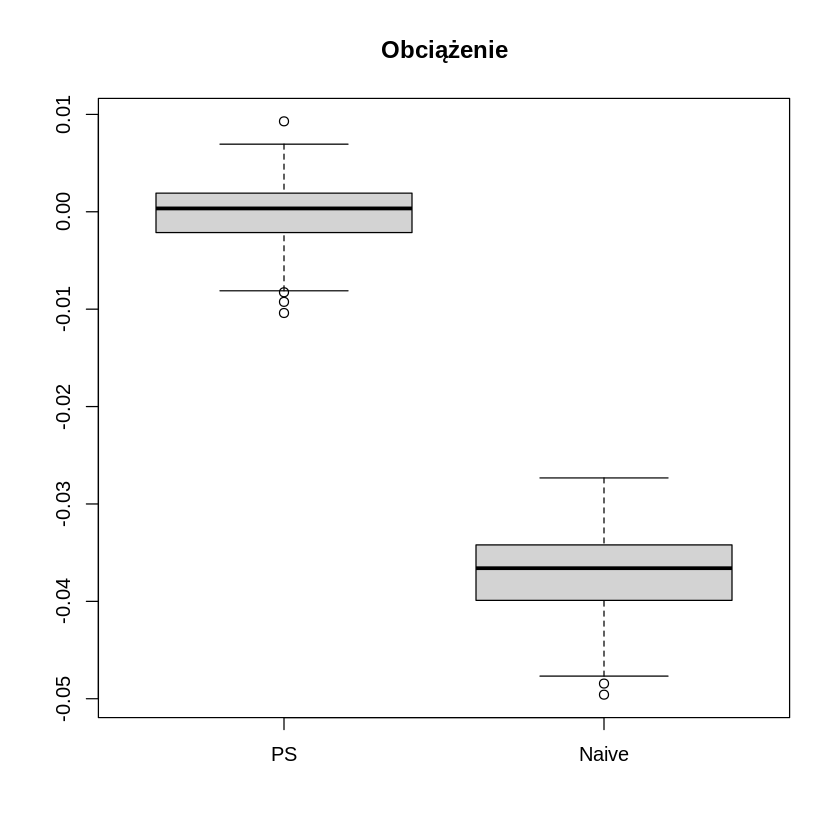

In [107]:
boxplot(wynik - mean(y), main = "Obciążenie")

MSE

In [108]:
bias <- colMeans(wynik) - mean(y)
var <- apply(wynik, 2, var)
mse <- bias^2 + vars
rmse <- sqrt(mse)
data.frame(bias, vars, mse, rmse)

,bias,vars,mse,rmse
,<dbl>,<dbl>,<dbl>,<dbl>
PS,-0.0003163903,0.0001498295,0.0001499296,0.01224457
Naive,-0.0373565950,0.0001947108,0.0015902259,0.03987764
